In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from SeConvNet import SeConvNet
from data_utils import ImageDetectionSet
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose,
    Normalize,
    Resize
)
plt.style.use("dark_background")

In [ ]:
BATCH_SIZE = 32
IMAGES_SIZE = (456, 456)
MEAN = [0.23, 0.23, 0.23]
STD = [0.23, 0.23, 0.23]

In [ ]:
transforms = Compose([
    Resize(size=IMAGES_SIZE),
    Normalize(mean=MEAN, std=STD)
])

In [ ]:
data_dir = "C:\\Users\\1\\Downloads\\lateralidade.v16i.coco"
trainset = ImageDetectionSet(
    data_dir=data_dir,
    data_split="train",
    transform=transforms
)
testset = ImageDetectionSet(
    data_dir=data_dir,
    data_split="test",
    # transform=transforms
)

In [ ]:
train_loader = DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE
)


c:\Users\1\Desktop\EDD\src\models\SeConv\data_utils.py:74: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  image.T,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[420 382 282 278]


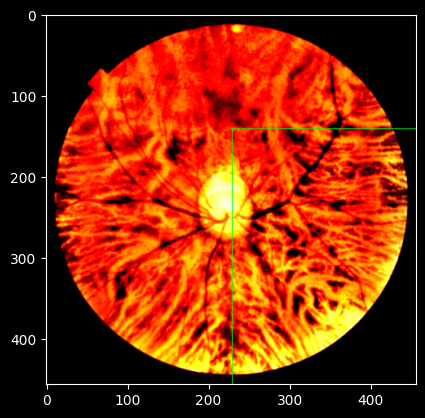

In [ ]:
for sample in train_loader:
    break

_, axis = plt.subplots()

idx = np.random.randint(0, 31)
image = sample[0][idx].numpy()
bbox = sample[2][idx].numpy().astype(np.int32)
bbox = (bbox * 2.0).astype(np.int32)
print(bbox)

start_point = np.array([
    bbox[0] - (bbox[1] // 2),
    bbox[2] - (bbox[2] // 2)
])

end_point = np.array([
    bbox[0] + (bbox[1] // 2),
    bbox[1] + (bbox[1] // 2)
])
image = cv2.rectangle(
    image,
    start_point,
    end_point,
    color=(0, 255, 0),
    thickness=1
)
axis.imshow(image)
plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow import reduce_mean

In [ ]:
train_images = []
train_labels = []
for i, batch in enumerate(train_loader):

    if i == 10:
        break

    images, labels, _ = batch
    train_images.append(images)
    train_labels.append(labels)

train_images = np.concatenate(train_images, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
OUT_CLASSES = np.unique(train_labels).shape[0]



In [ ]:
train_labels[train_labels == 1] = 0
train_labels[train_labels == 2] = 1
if OUT_CLASSES == 3:
    train_labels[train_labels == 3] = 2


In [ ]:
model = SeConvNet(
    input_sh=IMAGES_SIZE + (3, ),
    out_classes=OUT_CLASSES
)
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=SparseCategoricalCrossentropy()
)

In [ ]:
model_history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32
)

Epoch 1/10
10/10 [==============================] - 61s 6s/step - loss tracker: 0.6928 - acc tracker: 0.5156
Epoch 2/10
10/10 [==============================] - 55s 5s/step - loss tracker: 0.6928 - acc tracker: 0.5156
Epoch 3/10
10/10 [==============================] - 50s 5s/step - loss tracker: 0.6930 - acc tracker: 0.5156
Epoch 4/10
10/10 [==============================] - 47s 5s/step - loss tracker: 0.6935 - acc tracker: 0.5156
Epoch 5/10
10/10 [==============================] - 50s 5s/step - loss tracker: 0.6930 - acc tracker: 0.5156
Epoch 6/10
10/10 [==============================] - 50s 5s/step - loss tracker: 0.6934 - acc tracker: 0.5156
Epoch 7/10
10/10 [==============================] - 50s 5s/step - loss tracker: 0.6930 - acc tracker: 0.5156
Epoch 8/10
10/10 [==============================] - 50s 5s/step - loss tracker: 0.6927 - acc tracker: 0.5156
Epoch 9/10
10/10 [==============================] - 49s 5s/step - loss tracker: 0.6928 - acc tracker: 0.5156
Epoch 10/10
10/10 [

In [ ]:
model.save_weights("SeConvNet_weights.weights.h5")
# model.load_weights("SeConvNet_weights.weights.h5")

In [ ]:
input = model.model_.inputs
conv_out = model.model_.get_layer("multiply_2").output
inf_model = Model(inputs=input, outputs=conv_out)

In [ ]:
test_images = next(iter(train_loader))[0]
print(test_images.size())

torch.Size([32, 456, 456, 3])


In [ ]:
inf_out = inf_model(test_images.numpy())
inf_out = reduce_mean(inf_out, axis=-1)

In [ ]:
print(inf_out.shape)

(32, 57, 57)


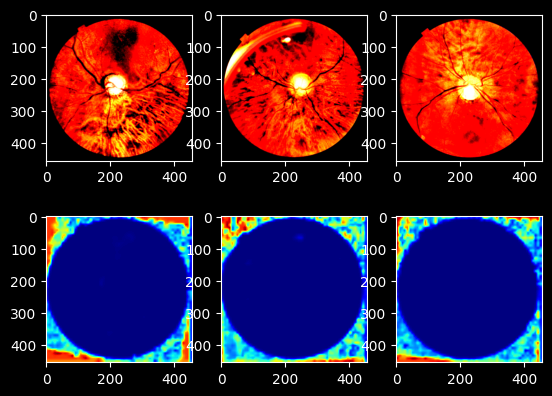

In [ ]:
_, axis = plt.subplots(ncols=3, nrows=2)
for i in range(axis.shape[1]):

    idx = np.random.randint(0, BATCH_SIZE)
    image = test_images[idx].numpy()

    heatmap = inf_out[idx].numpy()
    heatmap = cv2.resize(heatmap, IMAGES_SIZE)
    

    axis[0, i].imshow(image)
    axis[1, i].imshow(heatmap, cmap="jet")

plt.show()
    

In [ ]:
from torchvision.io import (
    read_video,
    write_video
)

vid_path = "C:\\Users\\1\\Desktop\\EDD\\Video2.mp4"
frames, _, _ = read_video(vid_path, output_format="THWC", start_pts=0, end_pts=12000)

c:\Users\1\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [ ]:
frames = frames.numpy()
frames = np.asarray([
    cv2.resize(frame, IMAGES_SIZE) / 256.0
    for frame in frames
])
heatmaps = reduce_mean(inf_model(frames), axis=-1).numpy()

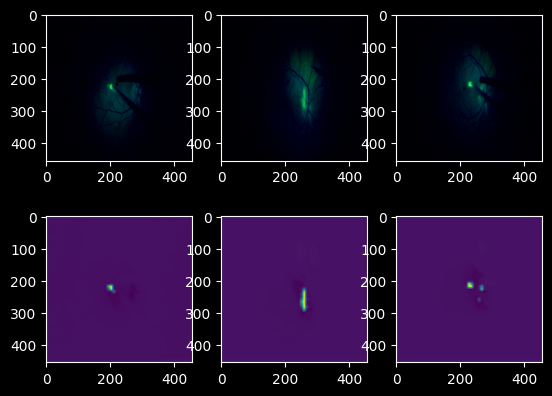

In [ ]:
_, axis = plt.subplots(ncols=3, nrows=2)
for i in range(axis.shape[1]):

    idx = np.random.randint(0, frames.shape[0])
    image = frames[idx]
    heatmap = heatmaps[idx]
    heatmap = cv2.resize(heatmap, IMAGES_SIZE)
    heatmap *= 167.45
    image[:, :, 0] *= heatmap
    image[:, :, 1] += heatmap
    # image[:, :, 2] += heatmap
    # heatmap = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_JET)
    # heatmaped_img = heatmap + image
    # heatmaped_img = heatmaped_img / 256.0
    
    

    axis[0, i].imshow(image)
    axis[1, i].imshow(heatmap)

plt.show()

In [ ]:
def img_sampling_(img, heatmap, temp=17.98):

    heatmap = cv2.resize(heatmap, IMAGES_SIZE)
    heatmap *= temp
    img[:, :, 0] += heatmap
    img[:, :, 1] += heatmap

    return np.uint(456 * img)

res_images = np.asarray([
    img_sampling_(img, heatmap)
    for (img, heatmap) in zip(frames, heatmaps)
])

In [ ]:
write_video(
    filename="res_video.mp4",
    video_array=res_images,
    fps=12
)